In [262]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [302]:
import numpy as np
import attr
import ujson
import torch

from itertools import islice
from tqdm import tqdm_notebook
from glob import glob

from gensim.models import KeyedVectors

from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [2]:
vectors = KeyedVectors.load_word2vec_format(
    '../data/vectors/GoogleNews-vectors-negative300.bin.gz',
    binary=True,
)

In [306]:
class Corpus:
    
    def __init__(self, pattern, skim=None):
        self.pattern = pattern
        self.skim = skim
        
    def lines(self):
        for path in glob(self.pattern):
            with open(path) as fh:
                for line in fh:
                    yield line.strip()

    def abstracts(self):
        lines = self.lines()
        if self.skim:
            lines = islice(lines, self.skim)
        for line in tqdm_notebook(lines, total=self.skim):
            raw = ujson.loads(line)
            yield Abstract.from_raw(raw)
            
    def xy(self):
        for abstract in self.abstracts():
            yield from abstract.xy()

In [325]:
@attr.s
class Abstract:
    
    sentences = attr.ib()
    
    @classmethod
    def from_raw(cls, raw):
        return cls([Sentence(s['token']) for s in raw['sentences']])
            
    def xy(self):
        for i, sent in enumerate(self.sentences):
            try:
                x = sent.tensor()
                y = i / (len(self.sentences)-1)
                y = torch.FloatTensor([y])
                yield x, y
            except RuntimeError as e:
                pass

In [326]:
@attr.s
class Sentence:
    
    tokens = attr.ib()
    
    def tensor(self):
        x = [vectors[t] for t in self.tokens if t in vectors]
        x += [np.zeros(300)] * 50
        x = x[:50]
        x = np.array(x)
        x = torch.from_numpy(x)
        x = x.float()
        return x

In [327]:
class Model(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(embed_dim, hidden_dim, nonlinearity='relu', batch_first=True)
        self.hidden2y = nn.Linear(hidden_dim, 1)
        
    def init_hidden(self):
        self.hidden = Variable(torch.zeros(1, 1, self.hidden_dim))
        
    def forward(self, x):
        rnn_out, self.hidden = self.rnn(x, self.hidden)
        y = self.hidden2y(self.hidden)
        return y

In [328]:
train = Corpus('../data/train.json/*.json', 1000)

In [329]:
train_xy = list(train.xy())

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [337]:
loader = DataLoader(train_xy, 10)

In [344]:
torch.manual_seed(1)

In [345]:
embed_dim = train_xy[0][0].shape[1]

In [346]:
model = Model(embed_dim, 150)

In [347]:
criterion = nn.MSELoss()

In [348]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [349]:
train_loss = []
for epoch in range(10):
    
    print(f'Epoch {epoch}')
    
    epoch_loss = 0
    for x, y in tqdm_notebook(loader):

        x = Variable(x)
        y = Variable(y)

        model.zero_grad()
        model.init_hidden()

        y_pred = model(x)

        loss = criterion(y_pred, y)
        loss.backward()

        optimizer.step()
        
        epoch_loss += loss.data[0]
        
    epoch_loss /= len(train_xy)
    train_loss.append(epoch_loss)
    print(epoch_loss)

Epoch 0


HBox(children=(IntProgress(value=0, max=547), HTML(value='')))


0.015565516700265436
Epoch 1


HBox(children=(IntProgress(value=0, max=547), HTML(value='')))


0.012387186923012636
Epoch 2


HBox(children=(IntProgress(value=0, max=547), HTML(value='')))


0.012336810856768441
Epoch 3


HBox(children=(IntProgress(value=0, max=547), HTML(value='')))


0.012295095968405756
Epoch 4


HBox(children=(IntProgress(value=0, max=547), HTML(value='')))


0.012254865037124934
Epoch 5


HBox(children=(IntProgress(value=0, max=547), HTML(value='')))


0.0121788146322395
Epoch 6


HBox(children=(IntProgress(value=0, max=547), HTML(value='')))


0.01202212641898385
Epoch 7


HBox(children=(IntProgress(value=0, max=547), HTML(value='')))


0.011229205061020965
Epoch 8


HBox(children=(IntProgress(value=0, max=547), HTML(value='')))


0.010237719145257918
Epoch 9


HBox(children=(IntProgress(value=0, max=547), HTML(value='')))


0.009725647486995892


In [285]:
train_loss = []
for epoch in range(10):
    
    print(f'Epoch {epoch}')
    
    epoch_loss = 0
    for x, y in tqdm_notebook(train_xy):

        # Add batch dimension.
        x = x.unsqueeze(0)
        y = y.unsqueeze(0)

        x = Variable(x)
        y = Variable(y)

        model.zero_grad()
        model.init_hidden()

        y_pred = model(x)

        loss = criterion(y_pred, y)
        loss.backward()

        optimizer.step()
        
        epoch_loss += loss.data[0]
        
    epoch_loss /= len(train_xy)
    train_loss.append(epoch_loss)
    print(epoch_loss)

Epoch 0


HBox(children=(IntProgress(value=0, max=5458), HTML(value='')))


0.12999921677057255
Epoch 1


HBox(children=(IntProgress(value=0, max=5458), HTML(value='')))


0.11499273352373027
Epoch 2


HBox(children=(IntProgress(value=0, max=5458), HTML(value='')))


0.10350951991053295
Epoch 3


HBox(children=(IntProgress(value=0, max=5458), HTML(value='')))


0.08901984128472874
Epoch 4


HBox(children=(IntProgress(value=0, max=5458), HTML(value='')))


0.07511331633338654
Epoch 5


HBox(children=(IntProgress(value=0, max=5458), HTML(value='')))


0.06172840180140791
Epoch 6


HBox(children=(IntProgress(value=0, max=5458), HTML(value='')))


0.04951520643183418
Epoch 7


HBox(children=(IntProgress(value=0, max=5458), HTML(value='')))


0.0387834653785514
Epoch 8


HBox(children=(IntProgress(value=0, max=5458), HTML(value='')))


0.02939293396460145
Epoch 9


HBox(children=(IntProgress(value=0, max=5458), HTML(value='')))


0.023268762448089456


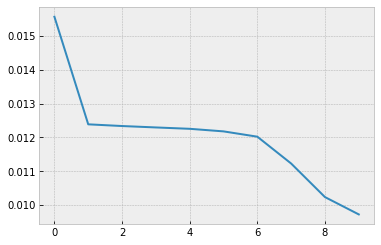

In [350]:
plt.plot(train_loss)